# Sampling $C_\ell$ spectra from Planck data

Strategy: Use Planck lite data and data covariance.

To consider: Use Planck lite covmat with full Planck means?

In [48]:
import os
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.io import FortranFile
from collections import namedtuple

import sklearn

In [2]:
from classy import Class
a = Class()
T_cmb = a.T_cmb()

In [3]:
height = 2
fontsize = 11/1.2
cm = 1/2.54  # centimeters in inches
width = 8.6*cm # PRL figure width
matplotlib.rcParams.update({
    'font.size'          : fontsize,
    'mathtext.fontset'   : 'cm',
})
Hubbles_to_Gyr = 0.001022

**Question**: What to actually take as input in the NN? 

Convention (subject to change): The Cls formatted as CLASS-output.

*Disadvantage*: Requires assuming constant $T_\mathrm{cmb}$ from CLASS. When does this change? Easy to get rid of: Just assume to take the input multiplied by $(T_\mathrm{cmb}\cdot10^6)^2$ (i.e. converted to $(\mu K)^2$).

### Load Planck lite data
Broadly copied from https://github.com/heatherprince/planck-lite-py/blob/master/planck_lite_py.py

In [4]:
def Cl2Dl(ll, Cl):
    return Cl*(ll*(ll + 1))/(2*np.pi)

def Dl2Cl(ll, Dl):
    return Dl/(ll*(ll + 1))*(2*np.pi)

In [60]:
class PlanckDataSampler:
    SamplesTuple = namedtuple('SamplesTuple', ['l_tt', 'tt', 'l_te', 'te', 'l_ee', 'ee'])
    factor = (T_cmb*1.e6)**2

    def __init__(self):
        self.calPlanck=1

        self.nbintt_hi = 215 #30-2508   #used when getting covariance matrix
        self.nbinte = 199 #30-1996
        self.nbinee = 199 #30-1996
        self.nbin_hi=self.nbintt_hi+self.nbinte+self.nbinee

        self.data_dir = '../data/planck2018_plik_lite/'
        self.cov_file = os.path.join(self.data_dir, 'c_matrix_plik_v22.dat')
        self.like_file = os.path.join(self.data_dir, 'cl_cmb_plik_v22.dat')
        self.blmin_file = os.path.join(self.data_dir, 'blmin.dat')
        self.blmax_file = os.path.join(self.data_dir, 'blmax.dat')
        self.binw_file = os.path.join(self.data_dir, 'bweight.dat')
        
        self.bval, self.X_data, self.X_sig=np.genfromtxt(self.like_file, unpack=True)
        self.blmin=np.loadtxt(self.blmin_file).astype(int)
        self.blmax=np.loadtxt(self.blmax_file).astype(int)
        self.bin_w=np.loadtxt(self.binw_file)

        self.nbintt=self.nbintt_hi
        self.nbin_tot=self.nbintt+self.nbinte+self.nbinee
        
        # Planck measured value
        self.Cl_tt = self.X_data[:self.nbintt]
        self.l_tt = self.bval[:self.nbintt]
        self.Dl_tt = Cl2Dl(self.l_tt, self.Cl_tt)
        self.Cl_te = self.X_data[self.nbintt:self.nbintt+self.nbinte]
        self.l_te = self.bval[self.nbintt:self.nbintt+self.nbinte]
        self.Dl_te = Cl2Dl(self.l_te, self.Cl_te)
        self.Cl_ee = self.X_data[self.nbintt+self.nbinte:]
        self.l_ee = self.bval[self.nbintt+self.nbinte:]
        self.Dl_ee = Cl2Dl(self.l_ee, self.Cl_ee)
        
        self.LCDM = {}
        lcdm_data = np.genfromtxt('../data/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt')
        lcdm_l = [float(k) for k in lcdm_data[:, 0]]
        def get_indices(ell_list, bin_centers):
            indices = []
            for l in ell_list:
                if l in bin_centers:
                    indices.append(int(l))
            return indices
        
        # TO DO: MULTIPLY WITH THE CORRECT calPlanck**2 (although I think this is just 1)
        self.LCDM['Dltt'] = lcdm_data[:, 1][get_indices(lcdm_l, self.bval[:self.nbintt])]
        self.LCDM['Dlte'] = lcdm_data[:, 2][get_indices(lcdm_l, self.bval[self.nbintt:self.nbintt+self.nbinte])]
        self.LCDM['Dlee'] = lcdm_data[:, 3][get_indices(lcdm_l, self.bval[self.nbintt+self.nbinte:])]
        self.LCDM['Cltt'] = Dl2Cl(self.l_tt, self.LCDM['Dltt'])
        self.LCDM['Clte'] = Dl2Cl(self.l_te, self.LCDM['Dlte'])
        self.LCDM['Clee'] = Dl2Cl(self.l_ee, self.LCDM['Dlee'])
        
        #read full covmat
        f = FortranFile(self.cov_file, 'r')
        covmat = f.read_reals(dtype=float).reshape((self.nbin_hi,self.nbin_hi))
        for i in range(self.nbin_hi):
            for j in range(i,self.nbin_hi):
                covmat[i,j] = covmat[j,i]

        # Assume always both TT, TE and EE
        bin_no=self.nbin_hi
        self.cov = covmat

    def sample_lcdm(self, size=1, sigma_scale=1, uncor=False):
        # Returns Cl samples with LCDM mean 
        if uncor:
            cov = np.eye(self.cov.shape[0])*np.diag(self.cov)*sigma_scale
        else:
            cov = self.cov
        samples = np.random.multivariate_normal(
            mean=np.concatenate([self.LCDM['Cltt'], self.LCDM['Clte'], self.LCDM['Clee']]), 
            cov=cov*sigma_scale,
            size=size
        )
        return self.SamplesTuple(tt=samples[:,:self.nbintt], te=samples[:,self.nbintt:self.nbintt+self.nbinte], ee=samples[:,self.nbintt+self.nbinte:],
                                 l_tt=self.l_tt, l_te=self.l_te, l_ee=self.l_ee)
        
    def sample_data(self, size=1, sigma_scale=1, uncor=False):
        # Returns Cl samples with data mean
        if uncor:
            cov = np.eye(self.cov.shape[0])*np.diag(self.cov)*sigma_scale
        else:
            cov = self.cov
        samples = np.random.multivariate_normal(
            mean=np.concatenate([self.Cl_tt, self.Cl_te, self.Cl_ee]), 
            cov=self.cov*sigma_scale,
            size=size
        )
        return self.SamplesTuple(tt=samples[:,:self.nbintt], te=samples[:,self.nbintt:self.nbintt+self.nbinte], ee=samples[:,self.nbintt+self.nbinte:],
                                 l_tt=self.l_tt, l_te=self.l_te, l_ee=self.l_ee)
    
    def sample_gp(self, ell_grid=None, size=1, sigma_scale=1, uncor=False):
        # BETTER: MAKE A SEPARATE GP FOR EACH SPECTRUM
        kernel = sklearn.gaussian_process.kernels.RBF(length_scale=1.0)
        gp_tt = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
        gp_te = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
        gp_ee = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
        gp_tt.fit([self.l_tt], [self.Cl_tt])
        gp_te.fit([self.l_te], [self.Cl_te])
        gp_ee.fit([self.l_ee], [self.Cl_ee])
        
        if ell_grid is not None:
            tt = gp_tt.predict(np.tile(ell_grid, (size, 1)), return_std=False)
            te = gp_te.predict(np.tile(ell_grid, (size, 1)), return_std=False)
            ee = gp_ee.predict(np.tile(ell_grid, (size, 1)), return_std=False)
            return self.SamplesTuple(tt=tt, te=te, ee=ee, l_tt=ell_grid, l_te=ell_grid, l_ee=ell_grid)
        else:
            tt = gp_tt.predict(np.tile(self.l_tt, (size, 1)), return_std=False)
            te = gp_te.predict(np.tile(self.l_te, (size, 1)), return_std=False)
            ee = gp_ee.predict(np.tile(self.l_ee, (size, 1)), return_std=False)
            return self.SamplesTuple(tt=tt, te=te, ee=ee, l_tt=self.l_tt, l_te=self.l_te, l_ee=self.l_ee)
    
    def interp_samples(self, samples):
        # Interpolates samples onto the full 2508-ell grid
        #if not isinstance(samples, self.SamplesTuple):
        #    raise ValueError('Input must be a SamplesTuple.')
        ell_grid = np.arange(1, 2508)
        
        interp_settings = {
            'kind': 'linear',
            'fill_value': 'extrapolate'
        }
        
        cls_interped = {}
        cls_interped['tt'] = []
        cls_interped['te'] = []
        cls_interped['ee'] = []
        for Cl_list in samples.tt:
            cl_tt_interped = scipy.interpolate.interp1d(self.l_tt, Cl_list, **interp_settings)(ell_grid)
            cls_interped['tt'].append(cl_tt_interped)
        for Cl_list in samples.te:
            cl_te_interped = scipy.interpolate.interp1d(self.l_te, Cl_list, **interp_settings)(ell_grid)
            cls_interped['te'].append(cl_te_interped)
        for Cl_list in samples.tt:
            cl_tt_interped = scipy.interpolate.interp1d(self.l_tt, Cl_list, **interp_settings)(ell_grid)
            cls_interped['ee'].append(cl_tt_interped)
        return self.SamplesTuple(tt=cls_interped['tt'], te=cls_interped['te'], ee=cls_interped['ee'],
                                 l_tt=ell_grid, l_te=ell_grid, l_ee=ell_grid)
    
    def get_samples_array(self, samples):
        #if not isinstance(samples, self.SamplesTuple):
        #    raise ValueError('Input must be a SamplesTuple.')
        # First row is ell, second row is Cl
        array_tt = np.vstack([samples.l_tt, samples.tt])
        array_te = np.vstack([samples.l_te, samples.te])
        array_ee = np.vstack([samples.l_ee, samples.ee])
        return np.concatenate([array_tt, array_te, array_ee], axis=1)
    
    def set_pca(self, samples: SamplesTuple, n_components):
        samples_aligned = np.concatenate([samples.tt, samples.te, samples.ee], axis=1)

        # CARRY OUT NORMALIZATION!

        self.pca = sklearn.decomposition.PCA(n_components=n_components)
        self.pca.fit(samples_aligned)

sampler = PlanckDataSampler()
test = sampler.sample_gp(size=5)

### Plot of data means

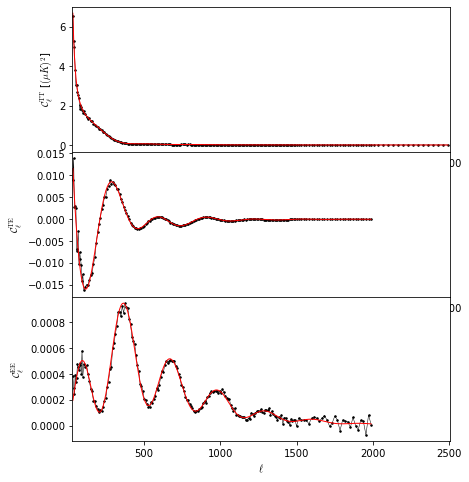

In [40]:
llim = [28, 2506]
marks = 3
lws=0.5

fig, ax = plt.subplots(3, 1, figsize=(2*width, 4*height))
ax[0].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$ [$(\mu K)^2$]', xscale='linear', xlim=llim)
ax[1].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0].plot(sampler.l_tt, sampler.Cl_tt, 'k.-', ms=marks, lw=lws)
ax[0].plot(sampler.l_tt, sampler.LCDM['Cltt'], 'r-', ms=marks, lw=1)
ax[1].plot(sampler.l_te, sampler.Cl_te, 'k.-', ms=marks, lw=lws)
ax[1].plot(sampler.l_te, sampler.LCDM['Clte'], 'r-', ms=marks, lw=1)
ax[2].plot(sampler.l_ee, sampler.Cl_ee, 'k.-', ms=marks, lw=lws)
ax[2].plot(sampler.l_ee, sampler.LCDM['Clee'], 'r-', ms=marks, lw=1)

fig.subplots_adjust(hspace=0)

Are the units OK compared to Fig. 1, 2 in https://arxiv.org/pdf/1807.06209.pdf?

# Drawing spectra from covmat

In [74]:
N = 1000
scale = 1
samples = sampler.sample_lcdm(N, sigma_scale=scale)

In [75]:
# Save samples
samples_interped = sampler.interp_samples(samples)
samples_array = sampler.get_samples_array(samples_interped)
np.savetxt(f'samples_{N}.txt', samples_array)

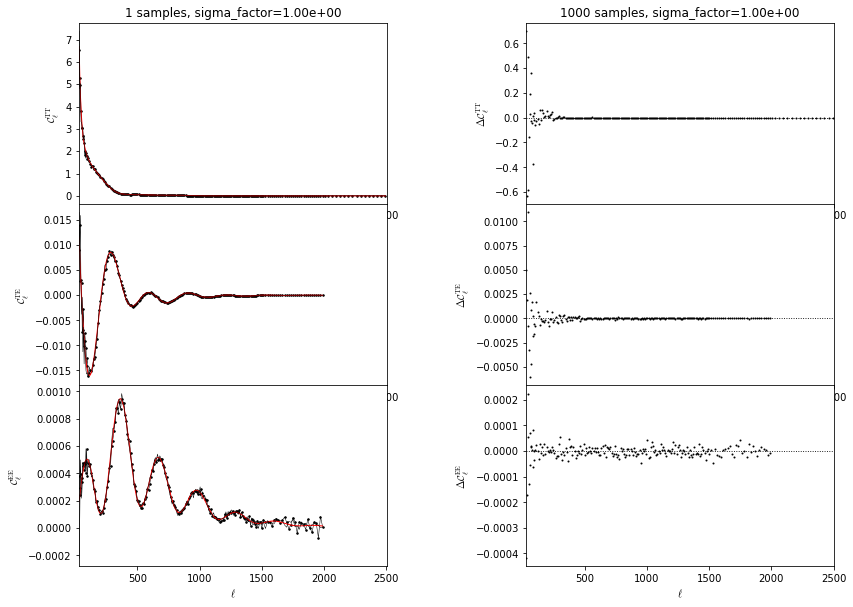

In [76]:
llim = [28, 2506]
marks = 3
lws=0.5
N_plot = 1
sample_alpha = 1.0009 - 0.000900901*N_plot
sample_ls = 0.50045 - 0.00045045*N_plot
fig, ax = plt.subplots(3, 2, figsize=(4*width, 5*height))
ax[0,0].set_title(f'{N_plot} samples, sigma_factor={scale:.2e}')
ax[0,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0,0].plot(sampler.l_tt, sampler.Cl_tt, 'k.-', ms=marks, lw=lws)
ax[0,0].plot(sampler.l_tt, sampler.LCDM['Cltt'], 'r-', ms=marks, lw=1)
ax[1,0].plot(sampler.l_te, sampler.Cl_te, 'k.-', ms=marks, lw=lws)
ax[1,0].plot(sampler.l_te, sampler.LCDM['Clte'], 'r-', ms=marks, lw=1)
ax[2,0].plot(sampler.l_ee, sampler.Cl_ee, 'k.-', ms=marks, lw=lws)
ax[2,0].plot(sampler.l_ee, sampler.LCDM['Clee'], 'r-', ms=marks, lw=1)
ax[0,1].set_title(f'{N} samples, sigma_factor={scale:.2e}')
ax[0,1].set(xticks=[],xticklabels=[],  ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], xticklabels=[], ylabel=r'$\Delta  \mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
for idx in range(N_plot):
    ax[0,0].plot(sampler.l_tt, samples.tt[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[1,0].plot(sampler.l_te, samples.te[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[2,0].plot(sampler.l_ee, samples.ee[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[0,1].plot(sampler.l_tt, samples.tt[idx] - sampler.LCDM['Cltt'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[0,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[1,1].plot(sampler.l_te, samples.te[idx] - sampler.LCDM['Clte'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[1,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[2,1].plot(sampler.l_ee, samples.ee[idx] - sampler.LCDM['Clee'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[2,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)

fig.subplots_adjust(hspace=0, wspace=0.45)
fig.savefig('samples.pdf')

# Sampling with Gaussian process

In [83]:
N = 1000
scale = 1
samples_gp = sampler.sample_gp(size=N)

N_plot = 1

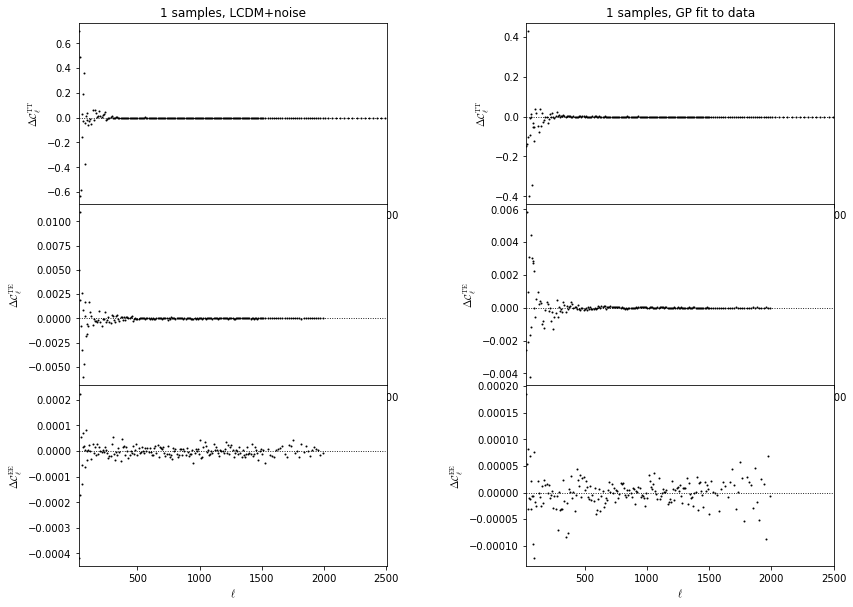

In [84]:
fig, ax = plt.subplots(3, 2, figsize=(4*width, 5*height))
ax[0,0].set_title(f'{N_plot} samples, LCDM+noise')
ax[0,0].set(xticks=[],xticklabels=[],  ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], xticklabels=[], ylabel=r'$\Delta  \mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
for idx in range(N_plot):
    ax[0,0].plot(sampler.l_tt, samples.tt[idx] - sampler.LCDM['Cltt'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[0,0].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[1,0].plot(sampler.l_te, samples.te[idx] - sampler.LCDM['Clte'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[1,0].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[2,0].plot(sampler.l_ee, samples.ee[idx] - sampler.LCDM['Clee'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[2,0].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
ax[0,1].set_title(f'{N_plot} samples, GP fit to data')
ax[0,1].set(xticks=[],xticklabels=[],  ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], xticklabels=[], ylabel=r'$\Delta  \mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
for idx in range(N_plot):
    ax[0,1].plot(sampler.l_tt, samples_gp.tt[idx] - sampler.LCDM['Cltt'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[0,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[1,1].plot(sampler.l_te, samples_gp.te[idx] - sampler.LCDM['Clte'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[1,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[2,1].plot(sampler.l_ee, samples_gp.ee[idx] - sampler.LCDM['Clee'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[2,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)

fig.subplots_adjust(hspace=0, wspace=0.45)
fig.savefig('samples_gp.pdf')

# PCA decomposition

In [10]:
# Uh oh! Need to make sure samples is the right kind of object.
sampler.set_pca(samples, n_components=10)